### 1.Introduction

House Prices - Advanced Regression Techniques コンペティションの特徴量エンジニアリング・プロジェクトへようこそ！
このコンペティションでは、Feature Engineering（特徴量エンジニアリング）コースの演習で使用したデータとほぼ同じデータを使います。
これまで行ってきた作業をまとめて、あなただけのアイデアを追加して発展させていけるような、ひとつの完成されたプロジェクトに仕上げていきましょう。

### 2.Preliminaries

#### Imports and Configuration

In [64]:
import os
import warnings
from pathlib import Path

from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor



#### Data Preprocessing


In [65]:
def ploting_cnt_amt(DataFile, Column, lim=2000):
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{Column} Distributions ', fontsize=24)
    
    plt.subplot(211)
    plot_1 = sns.countplot(x=Column,data=DataFile,palette="husl")
    plot_1_2 = plot_1.twinx()
    plot_1_2 = sns.pointplot(x=Column, y='SalePrice', data=DataFile,color='black', legend=False)
    sizes= []
    total = float(len(DataFile))
    for p in plot_1.patches:
        height = p.get_height()
        sizes.append(height)
        plot_1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
    plt.show()
    

In [66]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def CalcOutliers(df_num): 
    """
    外れ値は、平均±3x標準偏差 の範囲外にある値として定義されています(Zスコア的な方法)
    """
    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

特徴量エンジニアリングを行う前に、まずデータを分析に適した形式に前処理する必要があります。
コースで使用したデータはやや簡易的なものでしたが、Amesコンペティションのデータセットはもう少し複雑です。

このコンペティション用データセットでは、次の作業が必要です：

- CSVファイルからのデータ読み込み

- エラーや不整合のあるデータの修正（クレンジング）

- 統計的なデータ型のエンコード（数値型・カテゴリ型の識別と変換）

- 欠損値の補完（インピューテーション）




これらすべてのステップを関数にまとめることで、必要なときにいつでも新しいデータフレームを簡単に取得できるようにします。CSVファイルを読み込んだ後、次の3つの前処理ステップ（クリーン処理、エンコード、補完）を行い、その後データを分割します。1つはモデルの学習用の df_train、もう1つはコンペティションに提出してスコアを確認するための予測用 df_test です。


##### Clean Data

In [67]:
df = pd.read_csv('data/train.csv')

In [68]:
resumetable(df)

Dataset Shape: (1460, 81)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Id,int64,0,1460,1,2,3,10.51
1,MSSubClass,int64,0,15,60,20,60,2.92
2,MSZoning,object,0,5,RL,RL,RL,1.00
3,LotFrontage,float64,259,110,65.0,80.0,68.0,5.77
4,LotArea,int64,0,1073,8450,9600,11250,9.70
...,...,...,...,...,...,...,...,...
76,MoSold,int64,0,12,2,5,9,3.37
77,YrSold,int64,0,5,2008,2007,2008,2.29
78,SaleType,object,0,9,WD,WD,WD,0.78
79,SaleCondition,object,0,6,Normal,Normal,Normal,0.97


このデータセットに含まれるカテゴリカル変数の一部には、カテゴリに明らかな誤字と思われるものが含まれています。

In [69]:
df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

これらを data_description.txt と比較することで、どの項目にクリーニングが必要かが分かります。ここではいくつかの問題に対処しますが、さらにこのデータを詳しく評価してみるのも良いでしょう。

In [70]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

C:\Users\tatib\AppData\Local\Temp\ipykernel_13204\4262107936.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_1 = sns.countplot(x=Column,data=DataFile,palette="husl")


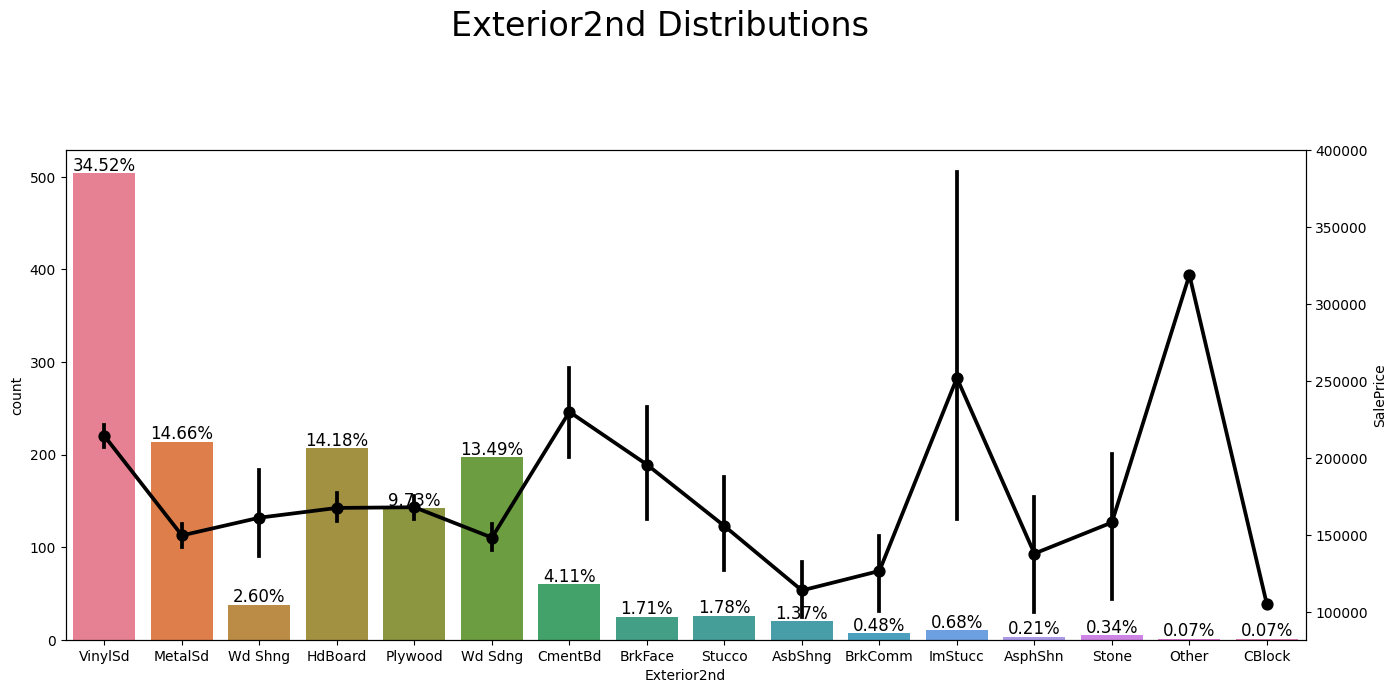

In [71]:
ploting_cnt_amt(clean(df), "Exterior2nd")

In [72]:
clean(df)["FirstFlrSF"].describe()

count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: FirstFlrSF, dtype: float64

In [73]:
clean(df)["FirstFlrSF"].dtypes # int64

dtype('int64')

In [75]:
clean(df)["SecondFlrSF"].describe()

count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: SecondFlrSF, dtype: float64

In [76]:
clean(df)["SecondFlrSF"].dtypes # int64

dtype('int64')

In [78]:
clean(df)["Threeseasonporch"].describe() # int64

count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: Threeseasonporch, dtype: float64

In [ ]:
clean(df)["Threeseasonporch"].dtypes # int64

dtype('int64')

##### Encode the Statical Data Type

Pandas には、標準的な統計型（数値型、カテゴリ型など）に対応する Python の型が用意されています。各特徴量に正しい型を割り当ててエンコードすることで、使用する関数がそれぞれの特徴量を適切に処理できるようになり、変換処理も一貫して適用しやすくなります。以下の非表示セルでは、encode 関数が定義されています。

In [ ]:
# 数値特徴量はすでに正しくエンコードされています（連続値には `float`、離散値には `int` が使われています）。
# しかし、カテゴリカル変数については自分でエンコードする必要があります。
# 特に注意すべきなのは、`MSSubClass` 特徴量です。これは `int` 型として読み込まれていますが、
# 実際には（順序のない）カテゴリ変数（名義尺度）です。

# 名義（順序のない）カテゴリカル特徴量

features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

In [ ]:
# 順序尺度（順序あり）の特徴量と、その取りうる値の順序を辞書で定義。
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

In [ ]:
# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


In [ ]:
def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df